# Loan Default Prediction

**DWDM Lab Project by Achintya Sharma and Nakul Rathore**

# Introduction to the Project
-  The Lending Club Business Model
-  Introduction to the Dataset

## Overview of the Project
- Exploratory Data Analysis
- Data Sanitization and Dimensionality Reduction
- Data Pre-Processing
- Dealing with imbalanced data
- Individual Models
    -  Logistic Regression
    -  Random Forest
    -  Support Vector Machine
- Ensemble Models
    - Voting Classifier
    - Weighted Average
- Conclusions

## Exploratory Data Analysis

In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from statistics import mode
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedBaggingClassifier, EasyEnsemble
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import Imputer, RobustScaler, FunctionTransformer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (roc_auc_score, confusion_matrix,
                             accuracy_score, roc_curve,
                             precision_recall_curve, f1_score)
from sklearn.pipeline import make_pipeline
import xgboost as xgb
from scipy.stats import boxcox
from sklearn.metrics import confusion_matrix

%matplotlib inline
plt.style.use("fivethirtyeight")
sns.set_context("notebook")

## Importing the data

In [2]:
data = pd.read_csv('LoanStats.csv', low_memory=False)

In [3]:
data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,University Medical Group,1 year,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


## Count & Percentage of Missing Values

In [4]:
df_null = pd.DataFrame({'Count': data.isnull().sum(), 'Percent': 100*data.isnull().sum()/len(data)})
df_null = df_null[df_null['Count'] > 0] 
print(df_null)

                                            Count     Percent
loan_amnt                                       3    0.007053
funded_amnt                                     3    0.007053
funded_amnt_inv                                 3    0.007053
term                                            3    0.007053
int_rate                                        3    0.007053
installment                                     3    0.007053
grade                                           3    0.007053
sub_grade                                       3    0.007053
emp_title                                    2629    6.180356
emp_length                                   1115    2.621186
home_ownership                                  3    0.007053
annual_inc                                      7    0.016456
verification_status                             3    0.007053
issue_d                                         3    0.007053
loan_status                                     3    0.007053
pymnt_pl

## Removing fields with more than 75% missing data

In [5]:
filtered_dataset = data.dropna(axis=1, thresh=int(0.75*len(data)))

## Filtered Dataset

In [6]:
filtered_dataset.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,hardship_flag,disbursement_method,debt_settlement_flag
0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,...,1.0,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N
1,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,...,1.0,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N
2,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,...,1.0,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N
3,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,...,1.0,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N
4,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,University Medical Group,1 year,...,1.0,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N


In [7]:
pruned_dataset = filtered_dataset.filter(['loan_amnt','term','int_rate','installment','grade','sub_grade','emp_length','home_ownership',
                    'annual_inc','verification_status','purpose','dti','delinq_2yrs','loan_status'])
pruned_dataset.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,loan_status
0,5000.0,36 months,10.65%,162.87,B,B2,10+ years,RENT,24000.0,Verified,credit_card,27.65,0.0,Fully Paid
1,2500.0,60 months,15.27%,59.83,C,C4,< 1 year,RENT,30000.0,Source Verified,car,1.00,0.0,Charged Off
2,2400.0,36 months,15.96%,84.33,C,C5,10+ years,RENT,12252.0,Not Verified,small_business,8.72,0.0,Fully Paid
3,10000.0,36 months,13.49%,339.31,C,C1,10+ years,RENT,49200.0,Source Verified,other,20.00,0.0,Fully Paid
4,3000.0,60 months,12.69%,67.79,B,B5,1 year,RENT,80000.0,Source Verified,other,17.94,0.0,Fully Paid


## Plotting Correlation Matrix

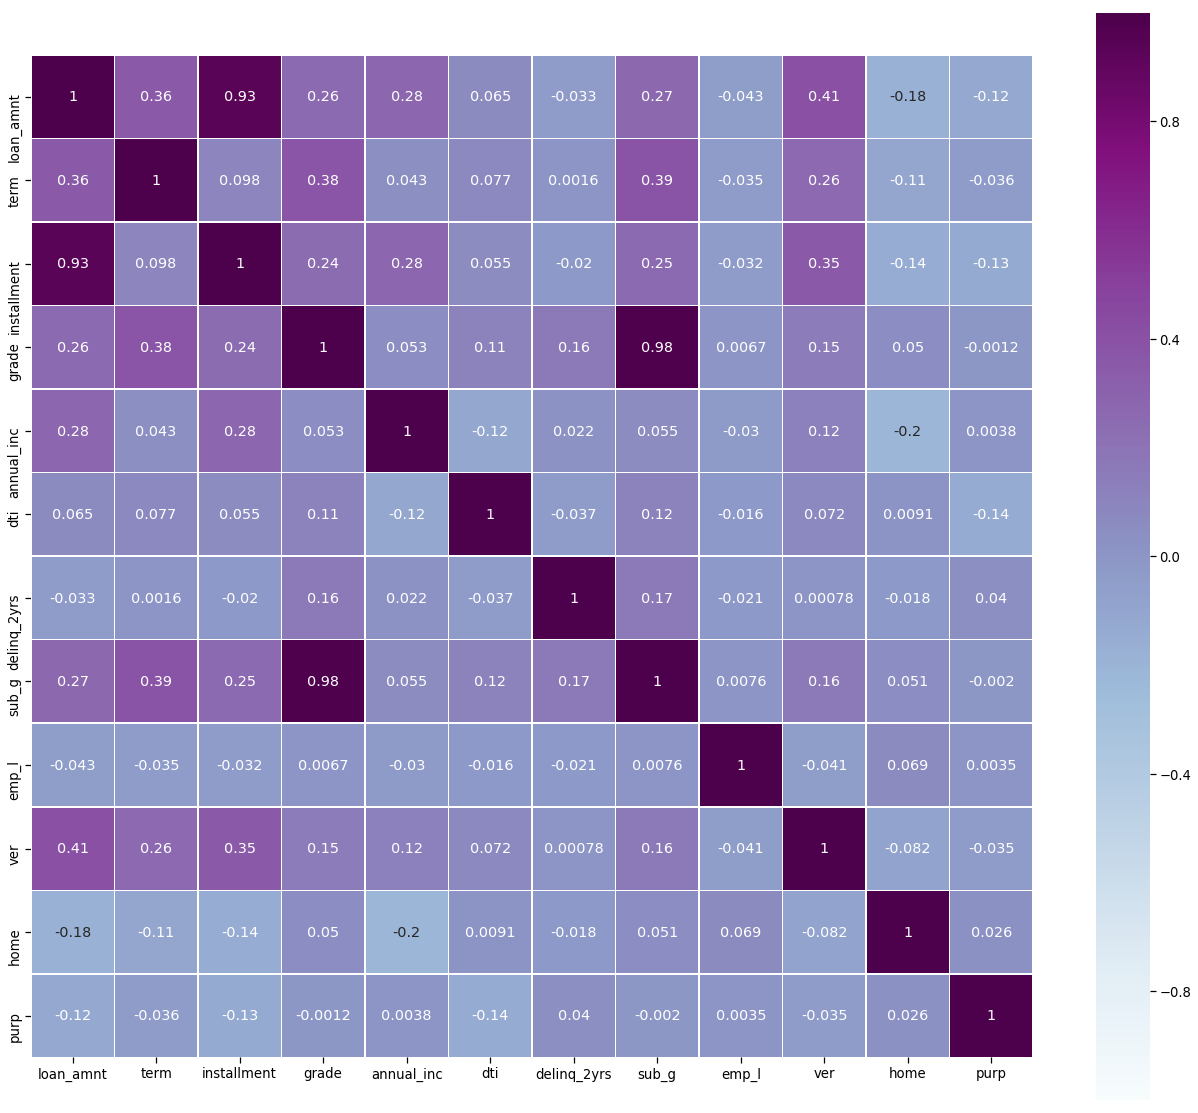

In [8]:
plt.figure(figsize=(20,20))
sns.set_context("notebook", font_scale=1.2)
##finding the correllation matrix and changing the categorical data to category for the plot.
sns.heatmap(pruned_dataset.assign(grade=pruned_dataset.grade.astype('category').cat.codes,
                         sub_g=pruned_dataset.sub_grade.astype('category').cat.codes,
                         term=pruned_dataset.term.astype('category').cat.codes,
                        emp_l=pruned_dataset.emp_length.astype('category').cat.codes,
                         ver =pruned_dataset.verification_status.astype('category').cat.codes,
                        home=pruned_dataset.home_ownership.astype('category').cat.codes,
                        purp=pruned_dataset.purpose.astype('category').cat.codes).corr(), 
                         annot=True, cmap='BuPu',vmin=-1, vmax=1, square=True, linewidths=0.5)

## Removing values that are highly correlated

In [9]:
pruned_dataset.drop(['installment','grade','sub_grade','verification_status','term'], axis=1, inplace=True)

## Finding fields with missing values

In [10]:
df_null1 = pd.DataFrame({'Count': pruned_dataset.isnull().sum(), 'Percent': 100*pruned_dataset.isnull().sum()/len(data)})
df_null1 = df_null1[df_null1['Count'] > 0] 
print(df_null1)

                Count   Percent
loan_amnt           3  0.007053
int_rate            3  0.007053
emp_length       1115  2.621186
home_ownership      3  0.007053
annual_inc          7  0.016456
purpose             3  0.007053
dti                 3  0.007053
delinq_2yrs        32  0.075227
loan_status         3  0.007053


## Strategies
- Imputation (Mean, Median, etc.): Too expensive computationally, minimal difference on result accuracy
- Removing missing values: Miniscule percentage missing, won't adversely effect our models

In [11]:
pruned_dataset=pruned_dataset.dropna(axis=0)

In [12]:
pruned_dataset['loan_status'].unique()

array(['Fully Paid', 'Charged Off',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

## Plotting and consolidating Loan Status Column

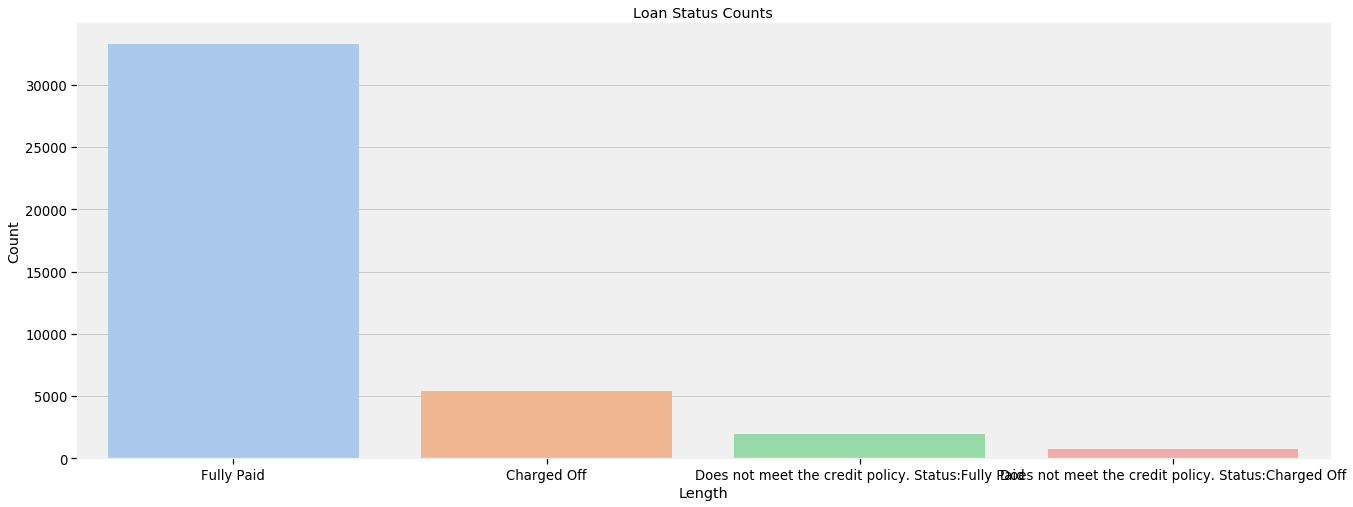

In [13]:
m =pruned_dataset['loan_status'].value_counts()
m = m.to_frame()
m.reset_index(inplace=True)
m.columns = ['Loan Status','Count']
plt.subplots(figsize=(20,8))
sns.barplot(y='Count', x='Loan Status', data=m, palette="pastel")
plt.xlabel("Length")
plt.ylabel("Count")
plt.title("Loan Status Counts")
plt.show()

In [14]:
pruned_dataset = pruned_dataset[pruned_dataset.loan_status != 'Does not meet the credit policy. Status:Fully Paid']
pruned_dataset = pruned_dataset[pruned_dataset.loan_status != 'Does not meet the credit policy. Status:Charged Off']

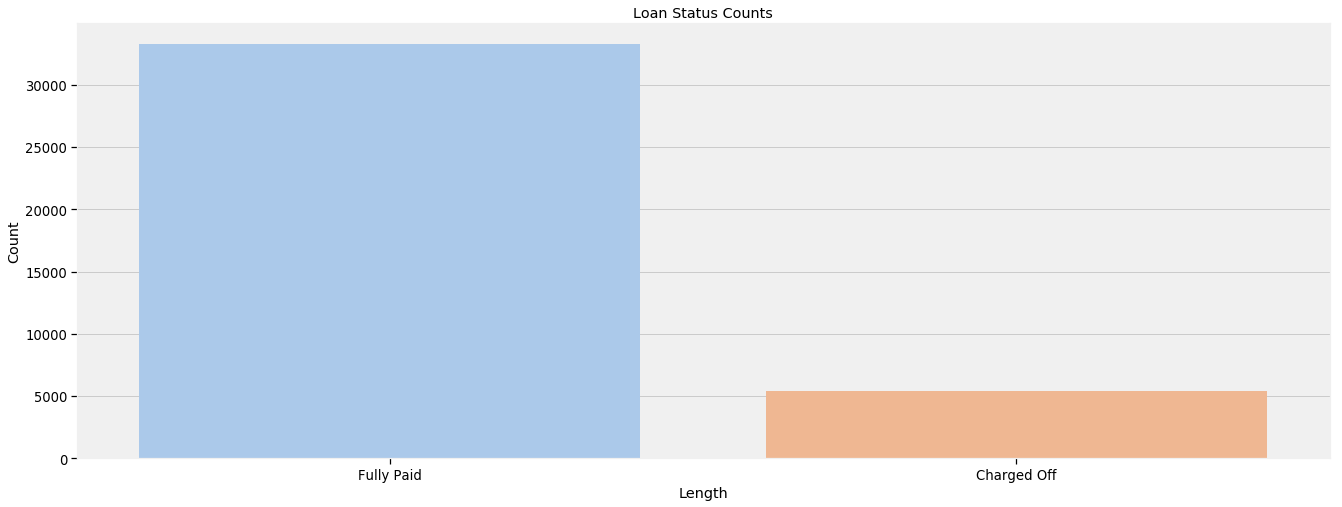

In [15]:
m =pruned_dataset['loan_status'].value_counts()
m = m.to_frame()
m.reset_index(inplace=True)
m.columns = ['Loan Status','Count']
plt.subplots(figsize=(20,8))
sns.barplot(y='Count', x='Loan Status', data=m, palette="pastel")
plt.xlabel("Length")
plt.ylabel("Count")
plt.title("Loan Status Counts")
plt.show()

## Results after consolidation

In [16]:
pruned_dataset.loan_status=pruned_dataset.loan_status.astype('category').cat.codes
pruned_dataset.delinq_2yrs=pruned_dataset.delinq_2yrs.astype('category').cat.codes
pruned_dataset.head()
pruned_dataset['loan_status'].value_counts()

1    33268
0     5440
Name: loan_status, dtype: int64

In [17]:
pruned_dataset.dtypes
pruned_dataset['int_rate']=pruned_dataset['int_rate'].str.replace(r'%$','')

## Need for Encoding

In [18]:
pruned_dataset['int_rate'] = pd.to_numeric(pruned_dataset['int_rate'])
pruned_dataset.dtypes

loan_amnt         float64
int_rate          float64
emp_length         object
home_ownership     object
annual_inc        float64
purpose            object
dti               float64
delinq_2yrs          int8
loan_status          int8
dtype: object

In [19]:
numerical = pruned_dataset.columns[pruned_dataset.dtypes == 'float64']
for i in numerical:
    if pruned_dataset[i].min() > 0:
        transformed, lamb = boxcox(pruned_dataset.loc[data[i].notnull(), i])
        if np.abs(1 - lamb) > 0.02:
            pruned_dataset.loc[data[i].notnull(), i] = transformed

## One Hot Encoding

In [20]:
pruned_dataset = pd.get_dummies(pruned_dataset, drop_first=True)

In [21]:
pruned_dataset.head()

,loan_amnt,int_rate,annual_inc,dti,delinq_2yrs,loan_status,emp_length_10+ years,emp_length_2 years,emp_length_3 years,emp_length_4 years,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
0,30.816240,4.513704,0.121513,27.65,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,25.155183,5.795436,0.121513,1.00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,24.852174,5.969072,0.121513,8.72,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,37.580554,5.328391,0.121513,20.00,0,1,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,26.547964,5.108420,0.121513,17.94,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


## Creating Training and Test Sets

In [22]:
traindata, testdata = train_test_split(pruned_dataset, stratify=pruned_dataset['loan_status'],test_size=.4, random_state=17)
testdata.reset_index(drop=True, inplace=True)
traindata.reset_index(drop=True, inplace=True)

## The Imbalanced Data Problem
- Over-Sampling
- Under-Sampling (Our choice)

In [23]:
sc = StandardScaler()
y_default = traindata[traindata['loan_status'] == 0]
n_paid = traindata[traindata['loan_status'] == 1].sample(n=len(y_default), random_state=17) ##chosing equal amount of 1's

data = y_default.append(n_paid) 

Xbal = data.drop('loan_status', axis=1)
ybal = data['loan_status']

Xte = testdata.drop('loan_status', axis=1)
yte = testdata['loan_status']

In [24]:
numerical = Xbal.columns[(Xbal.dtypes == 'float64') | (Xbal.dtypes == 'int64')].tolist()
Xbal[numerical] = sc.fit_transform(Xbal[numerical])

numerical = Xte.columns[(Xte.dtypes == 'float64') | (Xte.dtypes == 'int64')].tolist()
Xte[numerical] = sc.fit_transform(Xte[numerical])

In [25]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

models = {'RF': RandomForestClassifier(n_estimators=600), 'LR': LogisticRegression(C=1)}

balset = {}
for i in models.keys():
    scores = cross_val_score(models[i], Xbal - np.min(Xbal) + 1,
                                    ybal, scoring='roc_auc', cv=3)
    balset[i] = scores
    print(i, scores, np.mean(scores))

RF [0.6460717  0.64575111 0.63283024] 0.64155101666126
LR [0.68109659 0.69838327 0.66672777] 0.6820692086577278


# Individual Models

## Business Aspects

### Why some false-predictions are significantly more important than others

## Logistic Regression

In [26]:
modela = LogisticRegression(C=1)
modela.fit(Xbal,ybal)
predicta=modela.predict(Xte)

(0.0, 2.0, 2.0, 0.0)

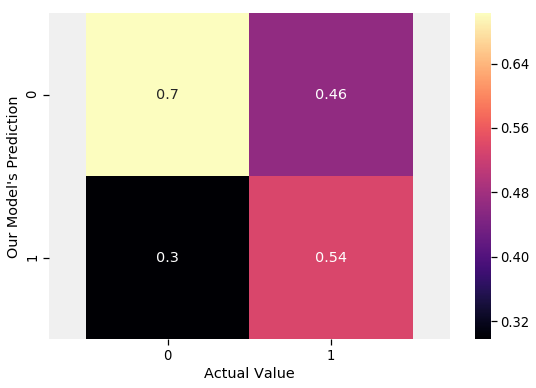

In [27]:
fig, axes = plt.subplots(figsize=(8,6))
cm = confusion_matrix(yte, predicta).T
cm = cm.astype('float')/cm.sum(axis=0)
ax = sns.heatmap(cm, annot=True, cmap='magma');
ax.set_xlabel('Actual Value')
ax.set_ylabel("Our Model's Prediction")
ax.axis('equal')

## Random Forest Classifier

In [28]:
modelb = RandomForestClassifier(n_estimators=800)
modelb.fit(Xbal,ybal)
predictb=modelb.predict(Xte)

(0.0, 2.0, 2.0, 0.0)

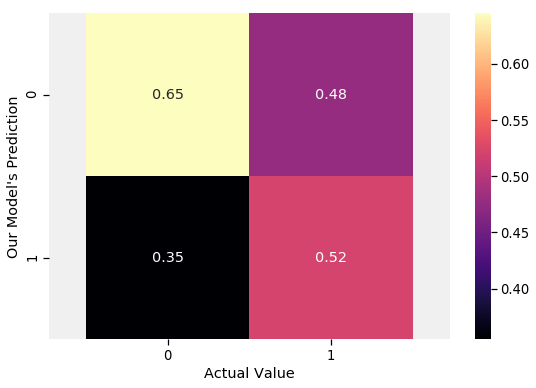

In [29]:
fig, axes = plt.subplots(figsize=(8,6))
cm = confusion_matrix(yte, predictb).T
cm = cm.astype('float')/cm.sum(axis=0)
ax = sns.heatmap(cm, annot=True, cmap='magma');
ax.set_xlabel('Actual Value')
ax.set_ylabel("Our Model's Prediction")
ax.axis('equal')

## Support Vector Machine

In [30]:
modelc = sklearn.svm.SVC(kernel="poly")
modelc.fit(Xbal, ybal)
predictc = modelc.predict(Xte)

(0.0, 2.0, 2.0, 0.0)

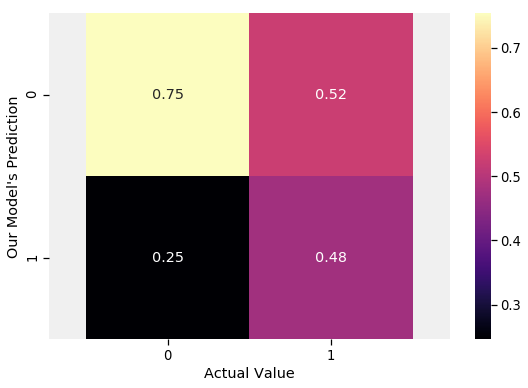

In [31]:
fig, axes = plt.subplots(figsize=(8,6))
cm = confusion_matrix(yte, predictc).T
cm = cm.astype('float')/cm.sum(axis=0)
ax = sns.heatmap(cm, annot=True, cmap='magma');
ax.set_xlabel('Actual Value')
ax.set_ylabel("Our Model's Prediction")
ax.axis('equal')

# Ensemble Models

## Voting Classifier
<img src="Voting.png">

In [32]:
voting_pred = np.array([])
for i in range(0,len(Xte)):
    voting_pred = np.append(voting_pred, mode([predicta[i], predictb[i], predictc[i]]))

(0.0, 2.0, 2.0, 0.0)

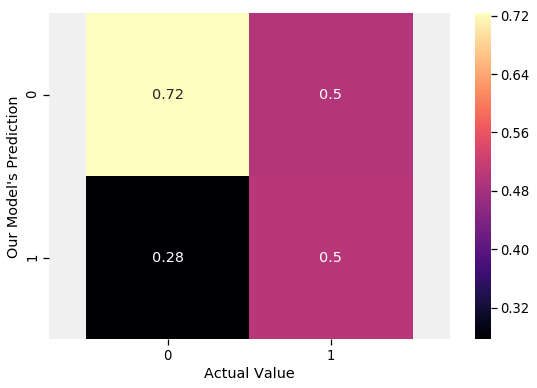

In [33]:
fig, axes = plt.subplots(figsize=(8,6))
cm = confusion_matrix(yte, voting_pred).T
cm = cm.astype('float')/cm.sum(axis=0)
ax = sns.heatmap(cm, annot=True, cmap='magma');
ax.set_xlabel('Actual Value')
ax.set_ylabel("Our Model's Prediction")
ax.axis('equal')

## Weighted Average
<img src="Weighted.png">

In [34]:
weighted_pred = (predicta*0.40+predictb*0.10+predictc*0.50)
weighted_pred[weighted_pred>0.5]=1
weighted_pred[weighted_pred<=0.5]=0

(0.0, 2.0, 2.0, 0.0)

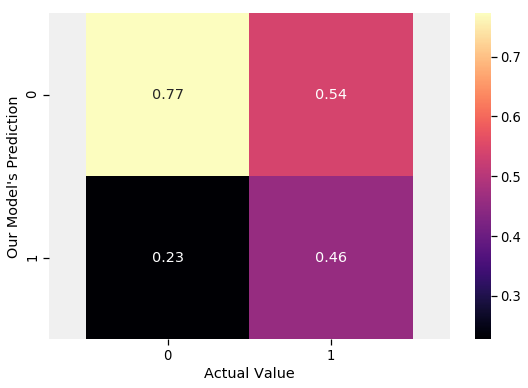

In [35]:
fig, axes = plt.subplots(figsize=(8,6))
cm = confusion_matrix(yte, weighted_pred).T
cm = cm.astype('float')/cm.sum(axis=0)
ax = sns.heatmap(cm, annot=True, cmap='magma');
ax.set_xlabel('Actual Value')
ax.set_ylabel("Our Model's Prediction")
ax.axis('equal')

# Conclusion